In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
matplotlib.rcParams.update({'font.size': 12})

In [2]:
def foo_k_r(T):
    return k_r0 * math.e**(-E_a/(R_u*T))

In [3]:
def foo_k(T, gas_name):
    if gas_name == 'H2':
        a0 = 0.3975
        a1 = 0.4814/10**4
        a2 = -1.073/10**7
        a3 = 4.6863/10**11
        a4 = -8.5361/10**15
        a5 = 5.6934/10**19
    elif gas_name == 'O2':
        a0 = 0.4697
        a1 = -2.9819/10**4
        a2 = 2.0320/10**7
        a3 = -7.1938/10**11
        a4 = 12.311/10**15
        a5 = -8.0736/10**19
    elif gas_name == 'H2O':
        a0 = 0.3834
        a1 = -1.8579/10**4
        a2 = 0.6266/10**7
        a3 = -1.0528/10**11
        a4 = 0.93554/10**15
        a5 = -0.38512/10**19
    else:
        print('Houston we have a problem')
    return 1 + a0 + a1*T + a2*T**2 + a3*T**3 + a4*T**4 + a5*T**5

In [4]:
def foo_alpha(r):
    if r != 0:
        a = 1 - math.e**(-r)
        return (1-a/r)/a
    else:
        return 0.5

In [31]:
# параметры установки
d = 45*10**(-3) # калибр
S = math.pi*d**2/4 # площадь
W_0 = 0.005 # объем каморы
l_d = 4.5 # длина ствола
m_elem = 0.52 # масса МЭ
p_0 = 34.5 * 10**6 # начальное давление
p_f = 172 * 10**6 # давление форсирования
k_r0 = 9.87 * 10**8 # предэскп. множитель 

Q_t = 13.4 * 10**6 # энергия образования 1 кг продуктов реакций ???
E_ign = 0 # энергия воспламенителя
E_a = 60*10**3 # энергия активации

v_p0 = 0 # начальная скорость
x_p0 = 0 # начальная координата
p_a = 10**5 # атмосфэрное давление

In [32]:
mu_H2 = 2*10**(-3) # молярная масса водорода
mu_O2 = 32*10**(-3) # молярная масса кислорода
mu_H2O = 18*10**(-3) # молярная масса воды

In [33]:
p_0 = 34.5 * 10**6 # начальное давления
T_0 = 300 # начальная температура
R_u = 8.31446262 # универсальная газовая постоянная
hi_O2_and_H2_0 = 8 # начальное соотношение мольных долей

In [34]:
# термодинамика
# R = foo_k_r * () # универсальная газовая постоянная
# m_g_0 = (2*mu_H2+mu_O2) * R_u * T_0/ (p_0 * W_0)
# print(m_g_0)
# rho_0 = m_g_0/W_0
# rho_0 = p_0/(R_u*T_0) # начальная плотность газа
# m_g_0 = rho_0*W_0 # начальная масса газа

# hi_O2_and_H2_0 = 8 # начальное соотношение мольных долей
# ratio_m_O2_and_m_H2_0 = hi_O2_and_H2_0*mu_O2/mu_H2 # начальное соотношение масс газа через мольные доли, скрин "мольные доли.png"

# m_H2_0 = m_g_0 / (ratio_m_O2_and_m_H2_0+1) # начальная масса водорода
# m_O2_0 = m_H2_0 * ratio_m_O2_and_m_H2_0 # начальная масса кислорода

# n_H2_0 = m_H2_0/mu_H2 # начальное количества вещества водорода
# n_O2_0 =  m_O2_0/mu_O2 # начальное количества вещества кислорода

# С_H2_0 = n_H2_0/W_0 # начальная молярная концентрация водорода
# С_O2_0 = n_O2_0/W_0 # начальная молярная концентрация кислорода

# C_H2O_0 = 0 # нет продуктов реакции в начальный момент времени

In [35]:
n_smesi = p_0 * W_0/(R_u * T_0)
m_O2_0 = n_smesi * mu_O2 / (hi_O2_and_H2_0 * mu_O2/mu_H2+1)
m_H2_0 = n_smesi * mu_H2 - m_O2_0 / mu_O2 * mu_H2

In [36]:
n_H2_0 = m_H2_0/mu_H2 # начальное количества вещества водорода
n_O2_0 =  m_O2_0/mu_O2 # начальное количества вещества кислорода

In [37]:
С_H2_0 = n_H2_0/W_0 # начальная молярная концентрация водорода
С_O2_0 = n_O2_0/W_0 # начальная молярная концентрация кислорода
C_H2O_0 = 0 # нет продуктов реакции в начальный момент времени

In [47]:
tau = 0 # время от начала процесса
C_n_1 = np.array([С_H2_0, С_O2_0, C_H2O_0]) # начальный вектор C
P_n = np.array([0, 0, foo_k_r(T_0)*C_n_1[0]*C_n_1[1]**(1/2)]) # начальный вектор Р
D_n = np.array([foo_k_r(T_0)*C_n_1[1]**(1/2), 1/2*foo_k_r(T_0)*C_n_1[0]*C_n_1[1]**(-1/2),0]) # начальный вектор D
W_n_1 = W_0 # начальный объем
v_p = v_p0 # начальная скорость

tau_arr = []
C_H2_arr = []
C_O2_arr = []
C_H2O_arr = []
m_H2_arr = []
m_O2_arr = []
m_H2O_arr = []
v_p_arr = []
p_m_arr = []
x_p_arr = []
M_p_arr = []
# rho_arr = []
T_arr = []

tau_arr = np.array(tau_arr)
C_H2_arr = np.array(C_H2_arr)
C_O2_arr = np.array(C_O2_arr)
C_H2O_arr = np.array(C_H2O_arr)
m_H2_arr = np.array(m_H2_arr)
m_O2_arr = np.array(m_O2_arr)
m_H2O_arr = np.array(m_H2O_arr)
v_p_arr = np.array(v_p_arr)
p_m_arr = np.array(p_m_arr)
x_p_arr = np.array(x_p_arr)
M_p_arr = np.array(M_p_arr)
# rho_arr = np.array(rho_arr)
T_arr = np.array(T_arr)

dt=5e-8
x_p = x_p0
T = T_0

schetchik=0

while x_p <= l_d: # условие цикла, пока МЭ не покинул дульный срез
    schetchik+=1
    tau += dt # время от начала процесса
    tau_arr = np.append(tau_arr, tau)
    
    C_n = C_n_1 # вектор С
    C_H2_arr = np.append(C_H2_arr, C_n[0])
    C_O2_arr = np.append(C_O2_arr, C_n[1])
    C_H2O_arr = np.append(C_H2O_arr, C_n[2])
    
    W_n = W_n_1
    
    n_H2 = C_n[0] * W_n # количество вещества водорода
    n_O2 = C_n[1] * W_n # количество вещества кислорода
    n_H2O = C_n[2] * W_n # количество вещества воды
    
    m_H2 = n_H2 * mu_H2 # масса водорода
    m_O2 = n_O2 * mu_O2 # масса кислорода
    m_H2O = n_H2O * mu_H2O # масса воды
    m_H2_arr = np.append(m_H2_arr, m_H2)
    m_O2_arr = np.append(m_O2_arr, m_O2)
    m_H2O_arr = np.append(m_H2O_arr, m_H2O)
    n_smesi = n_H2 + n_O2 + n_H2O # количество вещества смеси
    

    P_n = np.array([0, 0, foo_k_r(T)*C_n[0]*C_n[1]**(1/2)]) # вектор P
    D_n = np.array([foo_k_r(T)*C_n[1]**(1/2), 1/2*foo_k_r(T)*C_n[0]*C_n[1]**(-1/2),0]) # вектор D
    

    M_p = mu_H2O * C_n[2] * W_n # масса продуктов реакции
    M_p_arr = np.append(M_p_arr, M_p)

    phi = (1+(m_H2 + m_O2 + m_H2O)/(3*m_elem)) # фиктивность, масса всего
    
    # расчет показателя адиабаты смеси
    help_value = (n_H2/(foo_k(T,'H2')-1) + n_O2/(foo_k(T,'O2')-1) + n_H2O/(foo_k(T,'H2O')-1))**(-1)
    k_smesi = 1 + n_H2*help_value + n_O2*help_value + n_H2O*help_value # показатель адиабаты смеси для формулы 4.5
    
    
    p_m = (k_smesi-1)/W_n * ((p_0*W_0)/(foo_k(T_0, 'H2O')-1) + Q_t*M_p - E_ign - phi/2*m_elem*v_p**2) # среднебаллистическое давление

    p_m_arr = np.append(p_m_arr, p_m)

    T = p_m*W_n/(R_u*n_smesi)
    T_arr = np.append(T_arr,T)
    
    dv_p = (p_m - p_a)*S/(phi*m_elem) * dt # диф. скорости МЭ
    
    v_p += dv_p # скорость МЭ
    v_p_arr = np.append(v_p_arr, v_p)
    
    dx_p = v_p * dt # диф. координаты МЭ
    
    x_p += dx_p  # координата МЭ
    x_p_arr = np.append(x_p_arr, x_p)
    
    W_n_1 = W_0 + x_p*S  # Заснарядный объем на n+1 шаге
    
    W_n = W_0 + (x_p-dx_p)*S # Заснарядный объем на n шаге
           
    foo_alpha_res = np.array([]) # значение умножения алфа функции от произведения вектора D на tau, 
    for i in range(len(D_n)):
        foo_alpha_res = np.append(foo_alpha_res, foo_alpha(D_n[i]*tau))
        
    C_n_kr = W_n/W_n_1 * (C_n + (tau *(P_n-C_n*D_n))/(1+foo_alpha_res*D_n*tau)) # Предиктор вектора С
   
    # D_n_kr = (D_n*C_n_kr + D_n*C_n)/2 # Предиктор вектора D
    if C_n[0]>=1e-4 and C_n[1]>=1e-4:
        D_n_kr = (np.array([foo_k_r(T)*C_n_kr[1]**(1/2), 1/2*foo_k_r(T)*C_n_kr[0]*C_n_kr[1]**(-1/2),0]) + np.array([foo_k_r(T)*C_n[1]**(1/2), 1/2*foo_k_r(T)*C_n[0]*C_n[1]**(-1/2),0]))/2 # Предиктор вектора D
    else:
         D_n_kr = np.array([0,0,0])
    foo_alpha_res = np.array([]) # значение умножения алфа функции от произведения вектора D на tau, 
    for i in range(len(D_n_kr)):
        foo_alpha_res = np.append(foo_alpha_res, foo_alpha(D_n_kr[i]*tau))
    
    # P_n_kr = foo_alpha_res*P_n*C_n_kr + (1-foo_alpha_res)*P_n*C_n # Предиктор вектора P
    if C_n[0]>=1e-4 and C_n[1]>=1e-4:
        P_n_kr = foo_alpha_res*np.array([0, 0, foo_k_r(T)*C_n_kr[0]*C_n_kr[1]**(1/2)]) + (1-foo_alpha_res)*np.array([0, 0, foo_k_r(T)*C_n[0]*C_n[1]**(1/2)]) # Предиктор вектора P    
    else:
        P_n_kr = np.array([0, 0, 0])
    C_n_1 = W_n/W_n_1 * (C_n + (tau *(P_n_kr-C_n*D_n_kr))/(1+foo_alpha_res*D_n_kr*tau)) # Корректор вектора С
    
    if schetchik % 10000 == 0:
        print(x_p)

0.02615785795176285
0.10430534668969829
0.23276028009458896
0.40895041157428735
0.6296937434039895
0.8914841696787069
1.1907345451097353
1.5239552543668813
1.8878679360731916
2.2794658435991573
2.6960358097926336
3.1351554557376815
3.5946761333761112
4.072698841696741


In [48]:
len(tau_arr)

148654

In [49]:
v_p

1001.3532114020921

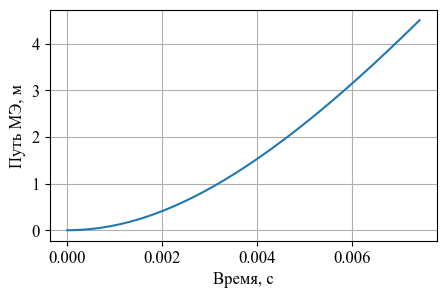

In [50]:
plt.figure(figsize=(5,3))
plt.plot(tau_arr, x_p_arr)
plt.xlabel('Время, с')
plt.ylabel('Путь МЭ, м')
plt.grid()

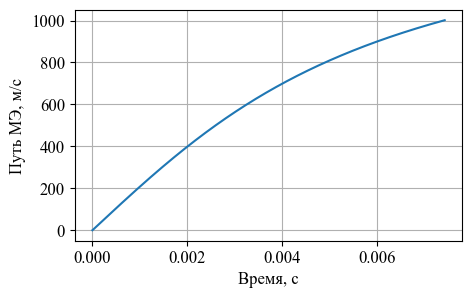

In [51]:
plt.figure(figsize=(5,3))
plt.plot(tau_arr, v_p_arr)
plt.xlabel('Время, с')
plt.ylabel('Путь МЭ, м/с')
plt.grid()

In [52]:
m_H2_arr, m_O2_arr, m_H2O_arr

(array([0.13724101, 0.13724085, 0.13724052, ..., 0.13342062, 0.13342062,
        0.13342062]),
 array([1.71551266e-02, 1.71537920e-02, 1.71512049e-02, ...,
        8.61746373e-16, 8.61746373e-16, 8.61746373e-16]),
 array([0.00000000e+00, 1.50144258e-06, 4.41202643e-06, ...,
        3.44718936e-02, 3.44718936e-02, 3.44718936e-02]))

In [53]:
# p_m зависит от v_p, v_p зависит от dv_p, что зависит от dt

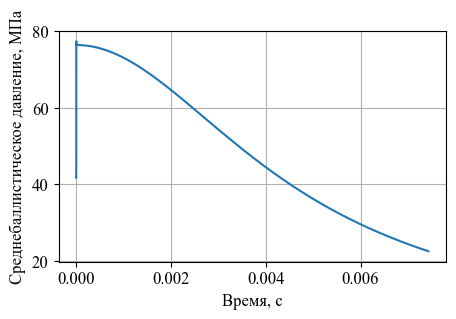

In [54]:
plt.figure(figsize=(5,3))
plt.plot(tau_arr, p_m_arr/10**6)
plt.xlabel('Время, с')
plt.ylabel('Среднебаллистическое давление, МПа')
plt.grid()